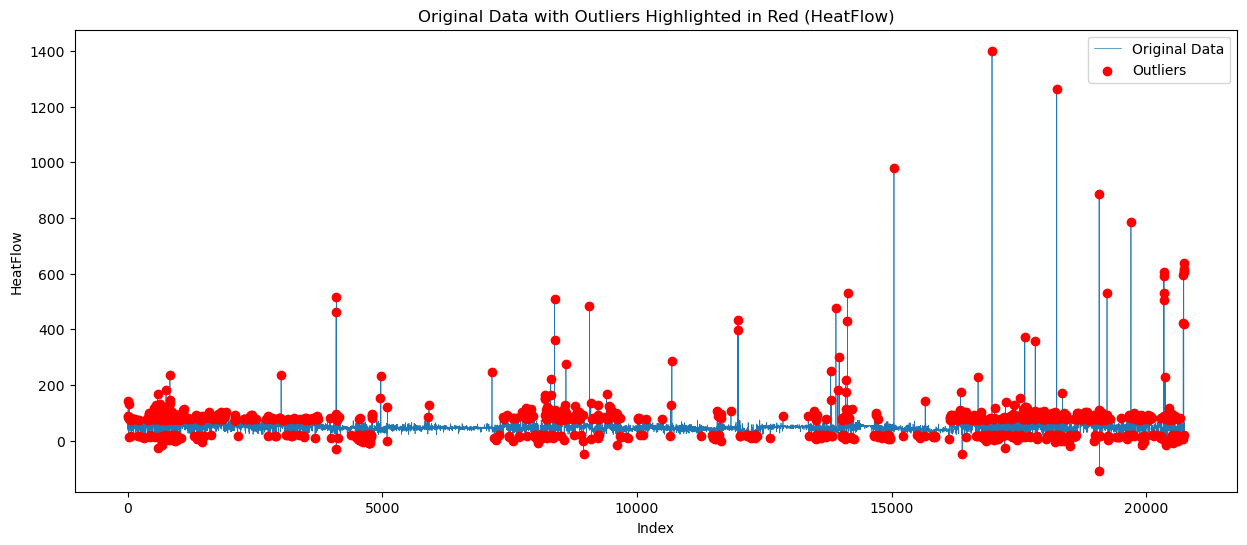

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('AASG_Thermed_AllTempsThicksConds.csv', low_memory=False)

features = ['LatDegree', 'LongDegree', 'MeasureDepth_m', 'SurfTemp', 'HeatFlow']
lat = data['LatDegree']
lon = data['LongDegree']
depth = data['MeasureDepth_m']
temp = data['SurfTemp']
heatf = data['HeatFlow']

def remove_outliers_iqr(data, column):
    # Calculate the first and third quartiles
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    
    # Calculate the IQR (Interquartile Range)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds to identify outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Create masks for outliers and non-outliers
    outliers_mask = (data[column] < lower_bound) | (data[column] > upper_bound)
    # Create a mask for non-outliers
    non_outliers_mask = (data[column] >= lower_bound) & (data[column] <= upper_bound)
    
    # Plot the original column values
    plt.figure(figsize=(15, 6))
    plt.plot(data.index, data[column], label='Original Data', linewidth=0.5)
    
    # Highlight outliers in red
    plt.scatter(data.index[outliers_mask], data[column][outliers_mask], color='red', label='Outliers', zorder=10)
    
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.legend()
    plt.title(f'Original Data with Outliers Highlighted in Red ({column})')
    plt.show()
    
    return data[non_outliers_mask].copy()

filtered_data = remove_outliers_iqr(data, 'HeatFlow')
    



# Fetching new well data

In [32]:

df2 = pd.read_csv('clean_new_well_data_fixed.csv')
num_sample=10000
sampled_df2 = df2.sample(num_sample)
sampled_df2.reset_index(inplace=True,drop=True)
sampled_df2.head()


,id,depth,temp,lat,lon,corrtemp
0,4705900805,1038.8346,34.138889,37.904429,-82.169272,38.922090
1,4705700106,689.7624,33.072222,39.453783,-78.827128,35.579473
2,4709100138,718.2612,25.588889,39.338962,-80.177553,28.281952
3,4707700185,1794.5100,46.316667,39.562450,-79.746017,56.026872
4,4705700106,925.9824,36.855556,39.453783,-78.827128,40.902961


In [40]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Interpolate Geological Layer information for X
lat_to_interpolate = sampled_df2.lat
lon_to_interpolate = sampled_df2.lon
layers = data.iloc[:,52:101].values
conds = data.iloc[:,101:150].values
mult = np.multiply(layers,conds)
np.nan_to_num(mult, 0)

f = open("optim_result.out", "r")
lines = f.readlines()

optimal_neigh = []
optimal_width = []
for line in lines:
    optimal_neigh.append(line.split(',')[0][0])
    optimal_width.append(line.split(',')[1])
optimal_neigh = np.array(optimal_neigh).astype('int')
optimal_width = np.array(optimal_width).astype('float')

# LightGBM for Layer Prediction
predicted_mults = []
for i in range(49):
    lgb_params = {'objective': 'regression', 'metric': 'l1', 'boosting_type': 'gbdt',
                  'num_leaves': 31, 'learning_rate': 0.05, 'feature_fraction': 0.9}
    
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    lgb_model.fit(scaled_data, mult[:, i])
    
    y_pred = lgb_model.predict(np.transpose(np.array([lat_to_interpolate, lon_to_interpolate])))
    predicted_mults.append(y_pred)

predicted_mults = np.transpose(np.array(predicted_mults))

# LightGBM for Surface Temperature Prediction
lgb_tsurf_params = {'objective': 'regression', 'metric': 'l1', 'boosting_type': 'gbdt',
                    'num_leaves': 31, 'learning_rate': 0.05, 'feature_fraction': 0.9}
    
lgb_tsurf_model = lgb.LGBMRegressor(**lgb_tsurf_params)
lgb_tsurf_model.fit(scaled_data, data.SurfTemp)
predicted_tsurf = lgb_tsurf_model.predict(np.transpose(np.array([lat_to_interpolate, lon_to_interpolate])))

# Form X and Y
new_X = np.transpose(np.array([lat_to_interpolate, lon_to_interpolate, sampled_df2.depth, predicted_tsurf]))
new_X = np.concatenate((new_X, predicted_mults), axis=1)
new_Y = sampled_df2.corrtemp.values

# Split data for training and testing
X_train, X_test, Y_train, Y_test = train_test_split(new_X, new_Y, test_size=0.2, random_state=42)

# LightGBM for Final Prediction
final_lgb_params = {'objective': 'regression', 'metric': 'l1', 'boosting_type': 'gbdt',
                    'num_leaves': 31, 'learning_rate': 0.05, 'feature_fraction': 0.9}

lgb_final_model = lgb.LGBMRegressor(**final_lgb_params)
lgb_final_model.fit(X_train, Y_train)
Y_pred = lgb_final_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(Y_test, Y_pred)
print(f"Mean Absolute Error on the test set: {mae}")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 20750, number of used features: 2
[LightGBM] [Info] Start training from score 198.274418
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current va

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 20750, number of used features: 2
[LightGBM] [Info] Start training from score 382.854880
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current va

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 20750, number of used features: 2
[LightGBM] [Info] Start training from score 136.860838
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction 

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 20750, number of used features: 2
[LightGBM] [Info] Start training from score 281.616087
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction 

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 20750, number of used features: 2
[LightGBM] [Info] Start training from score 0.064277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

In [43]:

import numpy as np
from sklearn.model_selection import KFold

# Assuming your data is in the form of arrays X and y
X = new_X
y = new_Y

# Define LightGBM parameters
lgb_params = {'objective': 'regression', 'metric': 'l1', 'boosting_type': 'gbdt',
              'num_leaves': 31, 'learning_rate': 0.05, 'feature_fraction': 0.9}

# Define the number of splits for cross-validation
n_splits = 10  # You can adjust this based on your preference

# Initialize KFold cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store evaluation results
mae_scores = []

# Perform cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    # Train LightGBM model
    lgb_model = lgb.train(lgb_params, train_data, num_boost_round=1000, valid_sets=[val_data],
                         )

    # Predict on the validation set
    y_pred = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)

    # Evaluate Mean Absolute Error
    mae = mean_absolute_error(y_val, y_pred)
    mae_scores.append(mae)

# Display the average MAE across folds
average_mae = np.mean(mae_scores)
print(f"Average Mean Absolute Error across {n_splits} folds: {average_mae}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 3
[LightGBM] [Info] Start training from score 45.505316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 3
[LightGBM] [Info] Start training from score 45.658917
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 3
[LightGBM] [Info] Start training f

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming new_X and new_Y are your feature matrix and target vector
X = new_X
y = new_Y

# Standardize features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Assuming X, y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

# Define the SVM regressor
svm_regressor = SVR()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(svm_regressor, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Perform Grid Search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Predict on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the best model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error on the test set using the best model: {mae}")
